In [155]:
import random

from itertools import zip_longest

import networkx as nx

import numpy as np

import pandas as pd

import seaborn as sns

from pandas_ply import install_ply, X, sym_call

install_ply(pd)

%matplotlib inline

In [156]:
def print_edges(g):
    "Function to print edges"
    for (u, v, d) in g.edges(data=True):
        print(u, v, d)


def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # Taken from itertools recipes:
    # https://docs.python.org/2/library/itertools.html#recipes
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)


def rand_pairing(teams, s=None):
    "Generates random pairing of teams, for first round"
    random.seed(s)
    shuffled = random.sample(teams, len(teams))
    return grouper(shuffled, 2)


def win_prob(a, b, strengths):
    "Win probability, per BTL model"
    return(strengths[a] / (strengths[a] + strengths[b]))


def win(a, b, strengths):
    roll = np.random.uniform()
    return roll < win_prob(a, b, strengths)


def add_match(a, b, wins, g, strengths):
    g.add_edge(a, b, weight=0)
    if(win(a, b, strengths)):
        wins[a] += 1
    else:
        wins[b] += 1


def next_pairing(n_teams, g):
    pairs = list(zip(range(n_teams), nx.max_weight_matching(g).values()))
    return(pairs)


def rebalance(g, wins, beta=10, alpha=25):
    for (u, v, d) in g.edges(data=True):
        if(g.edge[u][v]['weight'] > 0):
            g.edge[u][v]['weight'] = (alpha - beta * abs(wins[u] - wins[v]))**2


def run_round(n_teams, g, wins, strengths):
    # add wins
    for a, b in next_pairing(n_teams, g):
        if(a > b):
            add_match(a, b, wins, g, strengths)

    rebalance(g, wins, 5, 20)


In [164]:
def run_tournament(n_teams=48, n_rounds=6, seed=None):
    # initiate complete graph
    g = nx.complete_graph(n_teams)

    # initiate teams, strengths, wins
    teams = list(range(n_teams))
    np.random.seed(seed) # reproducible strength
    strengths = np.random.lognormal(size=n_teams)
    #strengths = np.random.exponential(size=n_teams)
    wins = [0] * n_teams

    # initiate edges
    for (u, v, d) in g.edges(data=True):
        g.add_edge(u, v, weight=1)

    # add wins for first round
    np.random.seed(None)
    for a, b in rand_pairing(teams, seed):
        add_match(a, b, wins, g, strengths)

    for i in range(n_rounds - 1):
        #df = pd.DataFrame(list(zip(strengths, wins)), columns=['strength', 'wins'])
        #sns.lmplot(x = "strength", y = "wins", 
         #      data = run_tournament(n_teams, n_rounds, seed), palette="muted")
        run_round(n_teams, g, wins, strengths)

    df = pd.DataFrame(list(zip(strengths, wins)), columns=['strength', 'wins'])
    return(df)


In [165]:
def simulate_tournament(n_teams, n_rounds, seed = None, n_simul = 100):
    df = pd.DataFrame()
    for i in range(n_simul):
        df = df.append(pd.DataFrame(data = run_tournament(n_teams, n_rounds, seed)))
    return df
    
def plot_results(n_teams=48, n_rounds=6, seed=None):
    lm = sns.lmplot(x = "strength", y = "wins", 
               data = run_tournament(n_teams, n_rounds, seed), palette="muted")
    axes = lm.axes
    axes[0,0].set_ylim(0,6)
    axes[0,0].set_xlim(0,1)
    

In [168]:
res = simulate_tournament(48, 6, seed = 20, n_simul = 100)

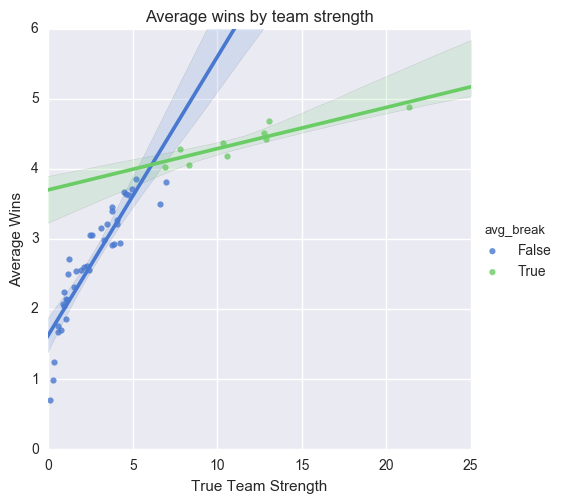

In [172]:
res_summ = (res
    .groupby('strength')
    .ply_select(
        strength = X.strength.mean(),
        avg_wins = X.wins.mean(),
        avg_break = X.wins.mean() > 4
    ))
#res_summ
lm = sns.lmplot(x = "strength", y = "avg_wins",
                hue = "avg_break",
               data = res_summ, palette="muted")
axes = lm.axes
axes[0,0].set_ylim(0,6)
axes[0,0].set_xlim(0,)
sns.plt.title("Average wins by team strength")
lm.set_xlabels("True Team Strength")
lm.set_ylabels("Average Wins")

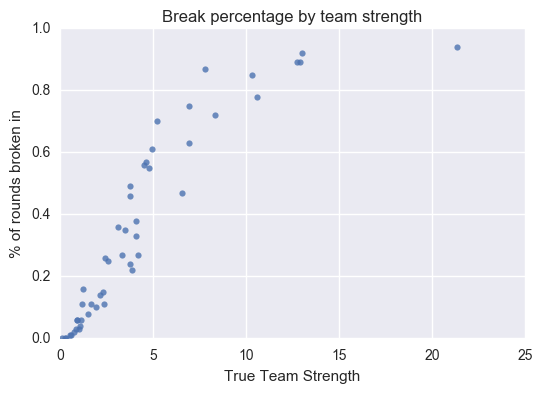

In [210]:
res_breaks = (res
    .groupby('strength')['wins']
    .agg({'n_break': lambda x : (x >= 4).mean()})
)
res_breaks.index.name = 'strength'
res_breaks.reset_index(inplace=True)

lm2 = sns.regplot(x = "strength", y = "n_break",
               data = res_breaks, fit_reg = False)
axes2 = lm2.axes
axes2.set_ylim(0,1)
axes2.set_xlim(0,)
sns.plt.title("Break percentage by team strength")
lm2.set_xlabel("True Team Strength")
lm2.set_ylabel("% of rounds broken in")

In [ ]:
# plot_results()